# 01. Train a Cat Dog classification model based on the (pretrained) VGG16 model.

__author__ : Phong Trung Le<br>
__email__ : letrungphong95@gmail.com

In [ ]:
!pip install tensorflow==2.0.0-rc0

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
import glob
import random
import cv2
import matplotlib.image as mpimg
%matplotlib inline
keras = tf.keras
print("Tensorflow version: {}".format(tf.__version__))
# default params
_IMAGE_SIZE = 224

Tensorflow version: 1.14.0


## 1.1 Download dataset and Convert to .tflite

Url: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [2]:
!ls data/PetImages

Cat  Dog  train.tfrecord  val.tfrecord


In [3]:
# check and unzip the dataset at `data/PetImages`
if os.path.isdir('data/PetImages') == False:
    print("Unzip the dataset")
    zip_ref = ZipFile('kagglecatsanddogs_3367a.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [4]:
# Split dataset to first 20K images for train set and last 5K images for validation set.
dataset_dir = 'data/PetImages/'

# get all image urls
image_paths = glob.glob(os.path.join(dataset_dir, '*/*.jpg'))

# shuffle image urls
random.seed(420)
random.shuffle(image_paths)

# split into train/val sets with ratio of 20K:5K
dataset = {
    'train': image_paths[:-5000],
    'val': image_paths[-5000:]
}

print("Dataset has been seperated into train and val sets.")

Dataset has been seperated into train and val sets.


In [5]:
# Build the tfrecord files for the dataset
# Helper functions
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def to_example(image_string, label):
    """ Create a dictionary with features (tf.Example) from the given image and label."""
    image_shape = tf.image.decode_jpeg(image_string).shape
    feature = {
        'height': _int64_feature(int(0.95*image_shape[0])),
        'width': _int64_feature(int(0.95*image_shape[1])),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(filenames, path, prefix='train'):
    """ Load images from given `filenames` and write into a tfrecord file.\
    
    Args:
    - filenames: list -- include image filenames/urls.
    - path: str -- where to save the tfrecord file.
    - prefix: str -- prefix for the name of the tfrecord file, e.g.: `train` or `val`.
    
    Return:
    - None.
    """
    save_path = os.path.join(path, prefix+'.tfrecord')
    with tf.io.TFRecordWriter(save_path) as writer:
        num_image = 0
        for filename in filenames:
            label = 0 if 'Cat' in filename else 1
            image_string = open(filename, 'rb').read()
            try:
                tf_example = to_example(image_string, label)
            except: # just ignore some corrupted images
                continue
            writer.write(tf_example.SerializeToString())
            num_image += 1
    print("Create tfrecord at: \n  - {}".format(os.path.join(path, prefix+'.tfrecord')))
    
# create tfrecord files for train and val sets, respectively.
for key in dataset.keys():
    write_tfrecord(dataset[key], 'data/PetImages/', key)    

Create tfrecord at: 
  - data/PetImages/train.tfrecord
Create tfrecord at: 
  - data/PetImages/val.tfrecord


## 1.2 Prepare data for training

In [6]:
# Create a dictionary describing the features.  
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

# Helper functions
def _parse_function(example_proto):
    """ Parse the data from given `example_proto`. """
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image_string = parsed_example['image_raw']
    label = parsed_example['label']
    height = parsed_example['height']
    weight = parsed_example['width']
    
    # Don't use tf.image.decode_image, or the output shape will be undefined
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image_decoded, tf.float32) # convert to float values in [0, 1]
    
    return image, label, height, weight

def _augment_image(image, label, height, weight):
    """ Augment image for training."""    
    image = tf.image.random_flip_left_right(image)        
    image = tf.image.random_crop(image, [height, weight, 3])
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0)                
    
    return image, label, height, weight
      
def _resize_image(image, label, height, weight, size):
    """ Resize image to meet the input size of the classification model. """
    resized_image = tf.image.resize_with_pad(image, size, size)   

    return resized_image, label

def _preprocess_image(image, label):
    """ Preprocess image to meet the VGG16 image preprocessing method."""
    # scale to [0, 255]
    preprocessed_image = 255.0*image
    
    # convert RGB to BGR
    preprocessed_image = preprocessed_image[...,::-1]
    
    # subtract the mean
    preprocessed_image = preprocessed_image - [103.939, 116.779, 123.68]
    
    return preprocessed_image, label    

In [7]:
# train data pipeline
train_dataset = (tf.data.TFRecordDataset('data/PetImages/train.tfrecord')
                     .map(_parse_function)
                     .map(_augment_image)
                     .map(lambda im, l, h, w: _resize_image(im, l, h, w, size=_IMAGE_SIZE))
                     .map(_preprocess_image)
                     .shuffle(1000)
                     .batch(32)
                     .prefetch(1)  # make sure you always have one batch ready to serve
                )

# val data pipeline
val_dataset = (tf.data.TFRecordDataset('data/PetImages/val.tfrecord')
                     .map(_parse_function)
                     .map(lambda im, l, h, w: _resize_image(im, l, h, w, size=_IMAGE_SIZE))
                     .map(_preprocess_image)
                     .batch(32)
                     .prefetch(1)  # make sure you always have one batch ready to serve                
              )
print(train_dataset)
print(val_dataset)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


## 1.3 Train VGG16 Cat Dog model

In [8]:
def model_fn(num_class=None, image_size=None):
    """
    This function creates initiative CNN model using VGG16 convolutional layer 
    and add some new layer on top to finetune our Dataset.  
    
    Arguments:
    -num_class: int, number of class for output of our model 
    (E.g: num_class=2 for Cat and Dog dataset)
    -image_size: int, size of input image from dataset for our model 
    
    Returns:
    - model: keras sequential model class, intiative model from keras   
    """
    # Define keras model 
    model = keras.models.Sequential()
    # Add the vgg16 convolutional base model
    model.add(keras.applications.VGG16(weights='imagenet', 
                                       include_top=False, 
                                       input_shape=(image_size, image_size, 3)))
    # Add new layers on top
    model.add(keras.layers.Conv2D(512, 1))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Conv2D(256, 1))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Conv2D(128, 1))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(num_class, activation='softmax'))
    
    return model

# Create initiative model
model = model_fn(num_class=2, image_size=_IMAGE_SIZE)

# Define model with optimizer method and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 512)         262656    
_________________________________________________________________
activation (Activation)      (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         131328    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0

## Train and save the dog/cat prediction model.

In [ ]:
# compile the model
# model.compile(optimizer=tf.optimizers.Adam(1e-5),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# train the model 
model.fit_generator(train_dataset, 
                    epochs=1, 
                    steps_per_epoch = 100)

# Evaluate on the val dataset 
val_loss, val_acc = model.evaluate_generator(val_dataset)
print("Val loss = {:.4f}, val acc = {:.4f}".format(val_loss, val_acc))

# Save keras model to .h5 file after training 
model.save('vgg16_catdog.h5')

## 1.4 Test model

In [2]:
model = tf.keras.models.load_model('saved/vgg16_catdog.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
def preprocess_image(path, size):
    """
    This function preprocess test image for prediction
    Arguments:
    -path: 
    -size:
    Returns:
    
    """
    # Read image from image path
    image_decoded = mpimg.imread(path)
    # convert to float values in [0, 1]
    image = image_decoded/ 255
    # resize image to fit the input size
    resized_image = cv2.resize(image, (size, size))
    # Scale to [0,255]
    resized_image = resized_image*255
    # Transpote from RGB to BGR then subtract for mean(imagenet)
    resized_image = resized_image[...,::-1] - [103.939,116.779,123.68]
    # Reshape tensor
    resized_image = resized_image.reshape((1, size, size, 3))
    return resized_image

Predict:  Cat
Confidence:  0.9476415


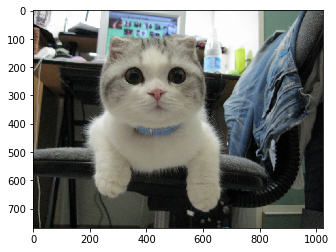

In [4]:
label = ['Cat','Dog']
test_path = '../samples/05.jpg'
# Read image to array (height,weight,3)
raw_image = mpimg.imread(test_path)
# Preprocess image 
test_image = preprocess_image(path=test_path, size=224)
# Predict 
result = model.predict(test_image)
print('Predict: ',label[result.argmax()])
print('Confidence: ',result.max())
plt.imshow(raw_image)